# Applied Data Analysis: CMU Movie Summary Corpus

## Introduction

In this notebook, we will explore and analyze the **CMU Movie Summary Corpus**. This dataset contains metadata and plot summaries for over 42,000 movies. The dataset is a rich resource for exploring relationships between movies, characters, and plot content.

### Dataset Details
- **Name**: CMU Movie Summary Corpus
- **Source**: [CMU Movie Summary Corpus Dataset](https://www.cs.cmu.edu/~ark/personas/)
- **Size**: 46 MB (compressed)
- **Typology**: Text + Graphs + Numerical Data
- **Tags**: Movies, Characters, Plot Summaries, Metadata

The dataset contains:
- **Movie Metadata**: Information about the movies such as titles, genres, release dates.
- **Character Metadata**: Details about the characters in each movie.
- **Plot Summaries**: Textual summaries of movie plots extracted from Wikipedia.

You can read more about the dataset in the paper: [Bamman et al., 2013](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf).

## Step 1: Loading the Data

We'll start by loading the various dataset files and then performing initial cleaning. The files we'll be working with are:
- `plot_summaries.txt.gz` for movie plot summaries.
- `movie.metadata.tsv.gz` for movie metadata like titles, genres, and release dates.
- `character.metadata.tsv.gz` for character-level metadata.

In [1]:
import pandas as pd

# Load the plot summaries
plots = pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', header=None, names=['movie_id', 'summary'])

# Load movie metadata
movies = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep='\t', header=None,
                     names=['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'release_date', 'box_office_revenue', 
                            'runtime', 'languages', 'countries', 'genres'])

# Load character metadata
characters = pd.read_csv('MovieSummaries/character.metadata.tsv', sep='\t', header=None,
                         names=['wikipedia_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 
                                'actor_birth', 'actor_gender', 'actor_height', 'actor_ethnicity', 
                                'actor_name', 'actor_age', 'freebase_character_actor_id', 
                                'freebase_character_id', 'freebase_actor_id'])

# Preview the datasets
print(plots.head())
print(movies.head())
print(characters.head())

   movie_id                                            summary
0  23890098  Shlykov, a hard-working taxi driver and Lyosha...
1  31186339  The nation of Panem consists of a wealthy Capi...
2  20663735  Poovalli Induchoodan  is sentenced for six yea...
3   2231378  The Lemon Drop Kid , a New York City swindler,...
4    595909  Seventh-day Adventist Church pastor Michael Ch...
   wikipedia_movie_id freebase_movie_id  \
0              975900         /m/03vyhn   
1             3196793         /m/08yl5d   
2            28463795        /m/0crgdbh   
3             9363483        /m/0285_cd   
4              261236         /m/01mrr1   

                                          movie_name release_date  \
0                                     Ghosts of Mars   2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...   2000-02-16   
2                                        Brun bitter         1988   
3                                   White Of The Eye         1987   
4                 

## Step 2: Exploratory Data Analysis (EDA)

Let’s explore some summary statistics, check for missing data, and visualize the relationships between variables.

In [2]:
# Check for missing data in all datasets
print(plots.isnull().sum())
print(movies.isnull().sum())
print(characters.isnull().sum())

# Summary statistics for movie metadata
print(movies.describe())

# Average plot summary length
plots['summary_length'] = plots['summary'].apply(len)
print(f"Average summary length: {plots['summary_length'].mean()}")

movie_id    0
summary     0
dtype: int64
wikipedia_movie_id        0
freebase_movie_id         0
movie_name                0
release_date           6902
box_office_revenue    73340
runtime               20450
languages                 0
countries                 0
genres                    0
dtype: int64
wikipedia_movie_id                  0
freebase_movie_id                   0
release_date                     9995
character_name                 257875
actor_birth                    106145
actor_gender                    45609
actor_height                   295845
actor_ethnicity                344611
actor_name                       1228
actor_age                      158113
freebase_character_actor_id         0
freebase_character_id          257865
freebase_actor_id                 815
dtype: int64
       wikipedia_movie_id  box_office_revenue       runtime
count        8.174100e+04        8.401000e+03  6.129100e+04
mean         1.740784e+07        4.799363e+07  1.118192e+02
std    

## Step 3: Visualization

### Static visualization

We will first create static visualizations with **Matplotlib** and **Seaborn** to understand the distribution of key features like genre and plot summary length.

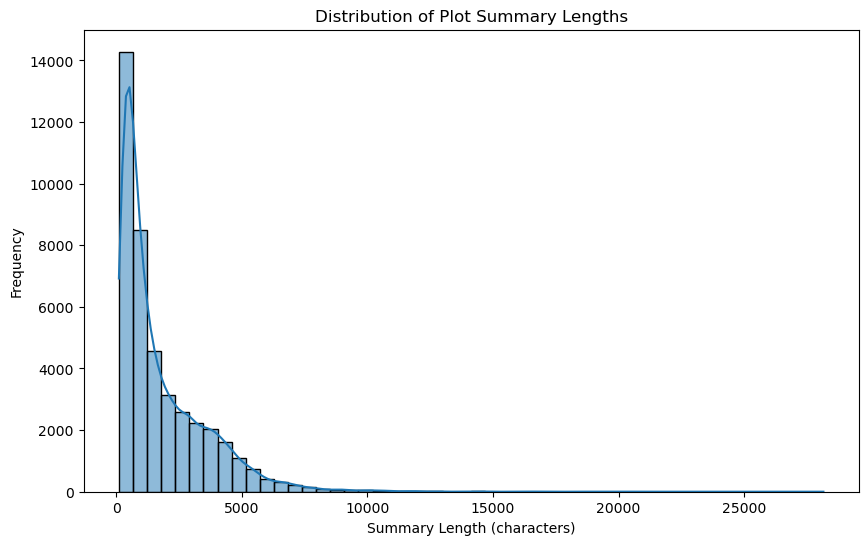

In [3]:
# Exploring the distribution of movie genres
genre_counts = movies['genres'].value_counts()

# Plotting summary lengths distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(plots['summary_length'], bins=50, kde=True)
plt.title('Distribution of Plot Summary Lengths')
plt.xlabel('Summary Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [7]:
from collections import Counter
import ast

# Function to extract genres from the dictionary-like string
def extract_genres(genre_str):
    try:
        # Convert the string to a dictionary
        genre_dict = ast.literal_eval(genre_str)
        # Return only the genre names (values in the dictionary)
        return list(genre_dict.values())
    except (ValueError, SyntaxError):
        # In case of a malformed string, return an empty list
        return []

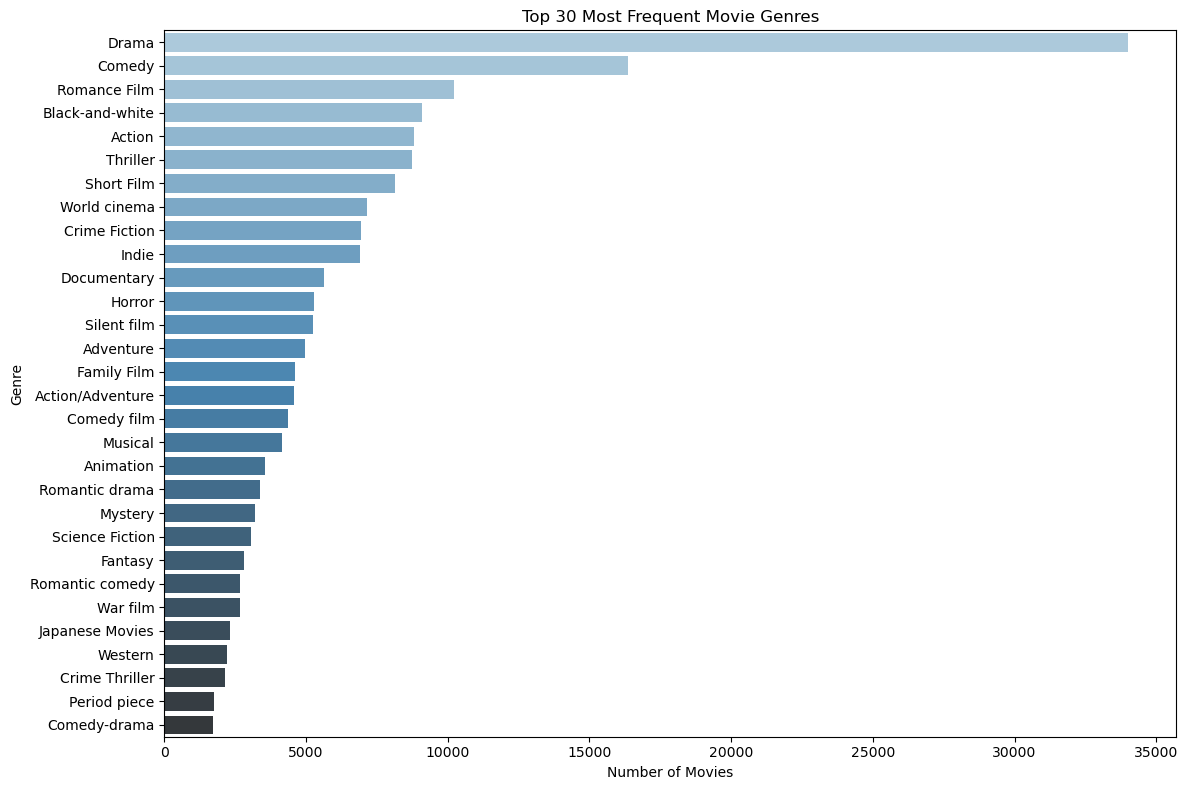

In [12]:
# Apply the extraction function to the 'genres' column
movies['genre_list'] = movies['genres'].apply(extract_genres)

# Flatten the list of genres and count occurrences using Counter
all_genres = movies['genre_list'].explode()
genre_counts = Counter(all_genres)

# Convert the Counter object to a DataFrame for easier plotting
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)

# Limit to the top 30 most frequent genres for better visualization
top_genres = genre_counts_df.head(30)

# Adjusting the figure size and plotting a horizontal bar plot
plt.figure(figsize=(12,8))
sns.barplot(data=top_genres, y='genre', x='count', hue='genre', palette="Blues_d", dodge=False)
plt.title('Top 30 Most Frequent Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

### Interactive Visualizations (Bokeh, Plotly, and Vega)

- Bokeh: Interactive Bar Plot for Movie Genres


Bokeh allows us to build highly interactive plots, making it ideal for understanding the distribution of movie genres interactively.


In [33]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Category20_20
from bokeh.transform import factor_cmap

output_notebook()  # for inline notebook output

# Keep the full genre list and convert to DataFrame
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['genre', 'count']).sort_values(by='count', ascending=False)

# Drop the NaN genres
genre_counts_df = genre_counts_df.dropna(subset=['genre'])

# Filter out genres with less than 20 occurrences (adjust threshold if needed)
genre_counts_df = genre_counts_df[genre_counts_df['count'] >= 200]

# Set a dynamic height based on the number of genres
dynamic_height = len(genre_counts_df) * 20  # Adjust for better spacing if needed

# Use a larger palette or repeat colors if necessary
# Adjust this depending on the number of genres. Category20_20 provides 20 distinct colors.
# If more genres exist, it will repeat colors.
num_genres = len(genre_counts_df)
palette = Category20_20 * (num_genres // 20 + 1)  # Repeat Category20_20 palette if more than 20 genres

# Create a color mapping based on genre counts
cmap = factor_cmap('genre', palette=palette[:num_genres], factors=genre_counts_df['genre'].tolist())

# Create a new figure with a scrollable y_range
p = figure(y_range=genre_counts_df['genre'].tolist(), height=dynamic_height, width=800, 
           title="Movie Genre Distribution (Genres with 20+ Occurrences)", tools="pan,box_zoom,reset,hover")

# Create horizontal bars with color mapping
p.hbar(y='genre', right='count', height=0.8, source=ColumnDataSource(genre_counts_df), color=cmap)

# Adjust axes labels and titles
p.xaxis.axis_label = 'Number of Movies'
p.yaxis.axis_label = 'Genre'
p.x_range.start = 0  # Set the x-axis start point to 0 for better alignment

# Show the scrollable plot
show(p)

Loading BokehJS ...

- Plotly: Interactive Distribution of Plot Summary Lengths

Plotly provides interactive controls and dynamic tooltips, enhancing exploration of data distributions.

In [37]:
import plotly.express as px

# Plot summary length distribution using Plotly
fig = px.histogram(plots, x='summary_length', nbins=50, title='Distribution of Plot Summary Lengths')
fig.update_layout(xaxis_title='Summary Length (characters)', yaxis_title='Frequency')
fig.show()

- Vega: Visualizing Word Frequencies in Plot Summaries

Let’s now explore word frequencies in plot summaries using Vega and Vincent for highly customizable, declarative visualizations.

In [56]:
import altair as alt
import pandas as pd
from collections import Counter
import re

# Combine all summaries into a single string
all_summaries = ' '.join(plots['summary']).lower()

# Tokenize and remove non-alphabetic characters
words = re.findall(r'\b[a-z]{3,}\b', all_summaries)

# Remove stopwords (optional)
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

# Count word frequencies
word_counts = Counter(filtered_words)

# Get the top 20 most common words
top_words = word_counts.most_common(20)

# Convert the list of top words to a DataFrame
df_top_words = pd.DataFrame(top_words, columns=['word', 'count'])

# Use Altair to create the bar chart
chart = alt.Chart(df_top_words).mark_bar().encode(
    x=alt.X('word:O', sort='-y'),  # Sort bars by frequency
    y='count:Q',
    tooltip=['word', 'count']  # Add tooltips to display word and count
).properties(
    title='Top 20 Most Common Words in Movie Summaries',
    width=600,  # Set width and height of the chart
    height=400
)

# Save the Vega-Lite JSON specification to a file
chart.save('vega_word_frequency.json')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abdou2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 4: Advanced Analysis (Optional)

We can dive deeper into the data by exploring NLP tasks like sentiment analysis, topic modeling, or even graph-based analysis using metadata like movie genres and characters.

- Sentiment Analysis on Plot Summaries

Let’s use a pre-built sentiment analysis model from the TextBlob library to analyze the sentiment of movie plot summaries.

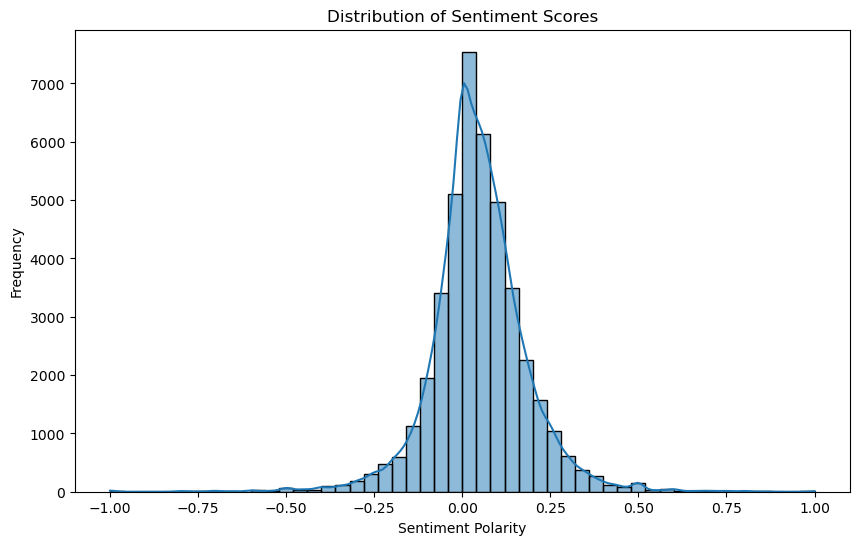

In [59]:
from textblob import TextBlob

# Function to compute sentiment polarity
def get_sentiment(summary):
    blob = TextBlob(summary)
    return blob.sentiment.polarity

# Apply sentiment analysis to plot summaries
plots['sentiment'] = plots['summary'].apply(get_sentiment)

# Distribution of sentiment scores
plt.figure(figsize=(10,6))
sns.histplot(plots['sentiment'], bins=50, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

- Graph Analysis of Characters and Movies

You can construct graphs using NetworkX to explore relationships between movies, actors, and characters.

## Conclusion

This notebook explored the **CMU Movie Summary Corpus** with a focus on loading, cleaning, and merging the data, followed by an exploratory analysis and various visualizations. The analysis offers a strong foundation for further deep-dive analysis, such as topic modeling, sentiment analysis, or graph-based exploration of movie characters and genres.

Feel free to extend the analysis using additional tools like **NLP**, **Graph Analysis**, or other advanced techniques.